# CW1--Decision Tree

#### Import the libraries

In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from collections import Counter

## 1. Loading Data

In [2]:
def load_data(file_path):
    file = np.loadtxt(file_path)
    labels = np.unique(file[:, -1])
    print(f"The shape of {file_path}: {file.shape}")
    print(f"The labels of {file_path}: {labels}")
    return file, labels

In [3]:
clean_file_path = 'wifi_db/clean_dataset.txt'
noisy_file_path = 'wifi_db/noisy_dataset.txt'
clean_data, clean_data_labels = load_data(clean_file_path)
noisy_data, noisy_data_labels = load_data(noisy_file_path)

The shape of wifi_db/clean_dataset.txt: (2000, 8)
The labels of wifi_db/clean_dataset.txt: [1. 2. 3. 4.]
The shape of wifi_db/noisy_dataset.txt: (2000, 8)
The labels of wifi_db/noisy_dataset.txt: [1. 2. 3. 4.]


The size of the data is 2000*8, which include 7 features and 1 label.

The labels are: 1, 2, 3, 4.

## 2. Creating Decision Tree
#### (1) Tree Node Class

In [4]:
class TreeNode:
    """
    Tree node class, which represents a node in the tree.
    """

    def __init__(self, leaf: bool = False, label: int = None, attr: int = None, value: float = None):
        """
        Tree node constructor.
        :param leaf: True if the node is a leaf node, False otherwise.
        :param label: The label of the node.
        :param attr: Feature attribute for splitting.
        :param value: Threshold of splitting.
        """
        self.leaf = leaf
        self.label = label
        self.attr = attr
        self.value = value
        self.left = None
        self.right = None

#### (2) Decision Tree Classifier

In [40]:
class DecisionTreeClassifier:
    """
    Decision Tree classifier class.
    """

    def __init__(self):
        self.root = None

    def entropy(self, dataset: np.ndarray) -> float:
        """
        Calculate the entropy of a dataset.
        :param dataset: Dataset to be classified.
        :return: Entropy of the dataset.
        """
        labels = dataset[:, -1]
        label_counts = Counter(labels)
        total_samples = len(labels)
        entropy_value = 0
        for label, count in label_counts.items():
            probability = count / total_samples
            entropy_value -= probability * math.log2(probability)
        return entropy_value

    def find_split(self, dataset: np.ndarray) -> tuple[tuple[int, float], np.ndarray, np.ndarray]:
        """
        Find a split in a dataset.
        :param dataset: Dataset to be split.
        :return: Split index and value of the dataset.
        """
        best_gain = -1
        best_split, best_left, best_right = None, None, None
        current_entropy = self.entropy(dataset)
        feature_num = len(dataset[0]) - 1  # The last column is label

        for feature in range(feature_num):
            sorted_data = dataset[dataset[:, feature].argsort()]
            for i in range(1, len(sorted_data)):
                if sorted_data[i, feature] != sorted_data[i - 1, feature]:
                    threshold = (sorted_data[i, feature] + sorted_data[i - 1, feature]) / 2
                    left_split = sorted_data[sorted_data[:, feature] <= threshold]
                    right_split = sorted_data[sorted_data[:, feature] > threshold]

                    if len(left_split) > 0 and len(right_split) > 0:
                        p_left = len(left_split) / len(dataset)
                        p_right = len(right_split) / len(dataset)
                        gain = current_entropy - (
                                p_left * self.entropy(left_split) + p_right * self.entropy(right_split))

                        # renew the tree
                        if gain > best_gain:
                            best_gain = gain
                            best_split = (feature, threshold)
                            best_left = left_split
                            best_right = right_split

        return best_split, best_left, best_right

    def build_tree(self, dataset: np.ndarray, depth: int = 0) -> TreeNode:
        """
        Build a decision tree.
        :param dataset: Dataset to be split.
        :param depth: The depth of the tree.
        :return: Decision tree.
        """
        labels = dataset[:, -1]

        # Base case
        if len(set(labels)) == 1:
            return TreeNode(leaf=True, label=labels[0])

        split, left, right = self.find_split(dataset)  # split: feature, threshold, left: left_split, right: right_split

        if split is None:
            label = Counter(labels.astype(int)).most_common(1)[0][0]
            return TreeNode(leaf=True, label=label)

        # Create the current node
        node = TreeNode(leaf=False, attr=split[0], value=split[1])

        # Recursively build the node of the tree
        node.left = self.build_tree(left, depth + 1)
        node.right = self.build_tree(right, depth + 1)

        return node

    def fit(self, dataset: np.ndarray) -> None:
        """
        Fit the tree to the dataset.
        :param dataset: Dataset to be split.
        :return: Decision tree.
        """
        self.root = self.build_tree(dataset)

    def classify(self, node: TreeNode, sample: np.ndarray) -> int:
        """
        Classify a node.
        :param node: TreeNode to be classified.
        :param sample: Feature array of a single sample.
        :return: 
        """
        if node.leaf:
            return node.label
        else:
            if sample[node.attr] > node.value:
                return self.classify(node.right, sample)
            else:
                return self.classify(node.left, sample)

    def predict(self, dataset: np.ndarray) -> list[int]:
        """
        Predict a dataset.
        :param dataset: Dataset to be split. (n_samples, n_features) without labels
        :return: Predicted dataset.
        """
        return [self.classify(self.root, sample) for sample in dataset]
    
    def cross_validation(self, dataset: np.ndarray, k: int = 10) -> dict:
        """
        Cross validate a dataset.
        :param dataset: Dataset to be split. (n_samples, n_features + 1) with labels
        :param k: k-fold cross validation.
        :return: a dictionary with confusion matrix, accuracy, precision, recall and f1-score.
        """
        # shuffle the dataset
        np.random.shuffle(dataset)
        fold_size = len(dataset) // k
        indices = np.arange(len(dataset))
        accuracies = []
        all_confusion_matrix = np.zeros((4, 4))  # 假设有4个分类（标签：1, 2, 3, 4）

        # 进行 K 折交叉验证
        for i in range(k):
            test_indices = indices[i * fold_size:(i + 1) * fold_size]
            train_indices = np.setdiff1d(indices, test_indices)

            train_data = dataset[train_indices]
            test_data = dataset[test_indices]

            # 训练决策树
            self.fit(train_data)

            # 对测试数据进行分类
            y_true = test_data[:, -1]  # 真实标签
            y_pred = self.predict(test_data[:, :-1])  # 预测标签

            # 计算准确率
            accuracy = np.sum(y_true == y_pred) / len(y_true)
            accuracies.append(accuracy)

            # 更新混淆矩阵
            confusion_matrix = self.compute_confusion_matrix(y_true, y_pred, num_classes=4)
            all_confusion_matrix += confusion_matrix

        # 平均准确率
        avg_accuracy = np.mean(accuracies)

        # 计算精确率、召回率和 F1 分数
        precision, recall, f1 = self.compute_precision_recall_f1(all_confusion_matrix)

        return {
            "confusion_matrix": all_confusion_matrix,
            "accuracy": avg_accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

    def compute_confusion_matrix(self, y_true, y_pred, num_classes):
        """计算混淆矩阵"""
        confusion_matrix = np.zeros((num_classes, num_classes))
        for t, p in zip(y_true, y_pred):
            confusion_matrix[int(t) - 1, int(p) - 1] += 1
        return confusion_matrix

    def compute_precision_recall_f1(self, confusion_matrix):
        """根据混淆矩阵计算精确率、召回率和 F1 分数"""
        tp = np.diag(confusion_matrix)  # True Positives
        precision = tp / np.sum(confusion_matrix, axis=0)  # 计算每一类的精确率
        recall = tp / np.sum(confusion_matrix, axis=1)     # 计算每一类的召回率
        f1 = 2 * (precision * recall) / (precision + recall)  # F1 分数
        # 如果出现 NaN，则设置为 0
        precision[np.isnan(precision)] = 0
        recall[np.isnan(recall)] = 0
        f1[np.isnan(f1)] = 0
        return precision, recall, f1

    def plot_tree(self, node: TreeNode = None, depth=0, x=0.5, y=1.0, dx=0.5, ax=None) -> None:
        """
        Plot a tree.
        :param node: Current node. 
        :param depth: Depth of the tree.
        :param x: The x-coordinate of the node.
        :param y: The y-coordinate of the node.
        :param dx: Offset of the x-axis.
        :param ax: Subplot of plot.
        """
        if node is None:
            node = self.root
            fig, ax = plt.subplots(figsize=(16, 12))
            ax.axis('off')

        # if leaf node
        if node.leaf:
            ax.text(x, y, f'Leaf: {node.label}', ha='center', va='center',
                    bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
        else:
            # if inner node, display the splitting rule
            ax.text(x, y, f'X{node.attr} <= {node.value:.2f}', ha='center', va='center',
                    bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

            # recursively plot the left subtree
            left_x = x - dx / (depth + 1)  # left subtree offset
            left_y = y - 0.1  # move down
            ax.annotate('', xy=(left_x, left_y), xycoords='data', xytext=(x, y), textcoords='data',
                        arrowprops=dict(arrowstyle="-", lw=1.5))
            self.plot_tree(node.left, depth + 1, left_x, left_y, dx * 0.9, ax)

            # recursively plot the right subtree
            right_x = x + dx / (depth + 1)  # right subtree offset
            right_y = y - 0.1  # move down
            ax.annotate('', xy=(right_x, right_y), xycoords='data', xytext=(x, y), textcoords='data',
                        arrowprops=dict(arrowstyle="-", lw=1.5))
            self.plot_tree(node.right, depth + 1, right_x, right_y, dx * 0.9, ax)

        if depth == 0:
            plt.show()

#### (3) Build a Treeeeee!!!

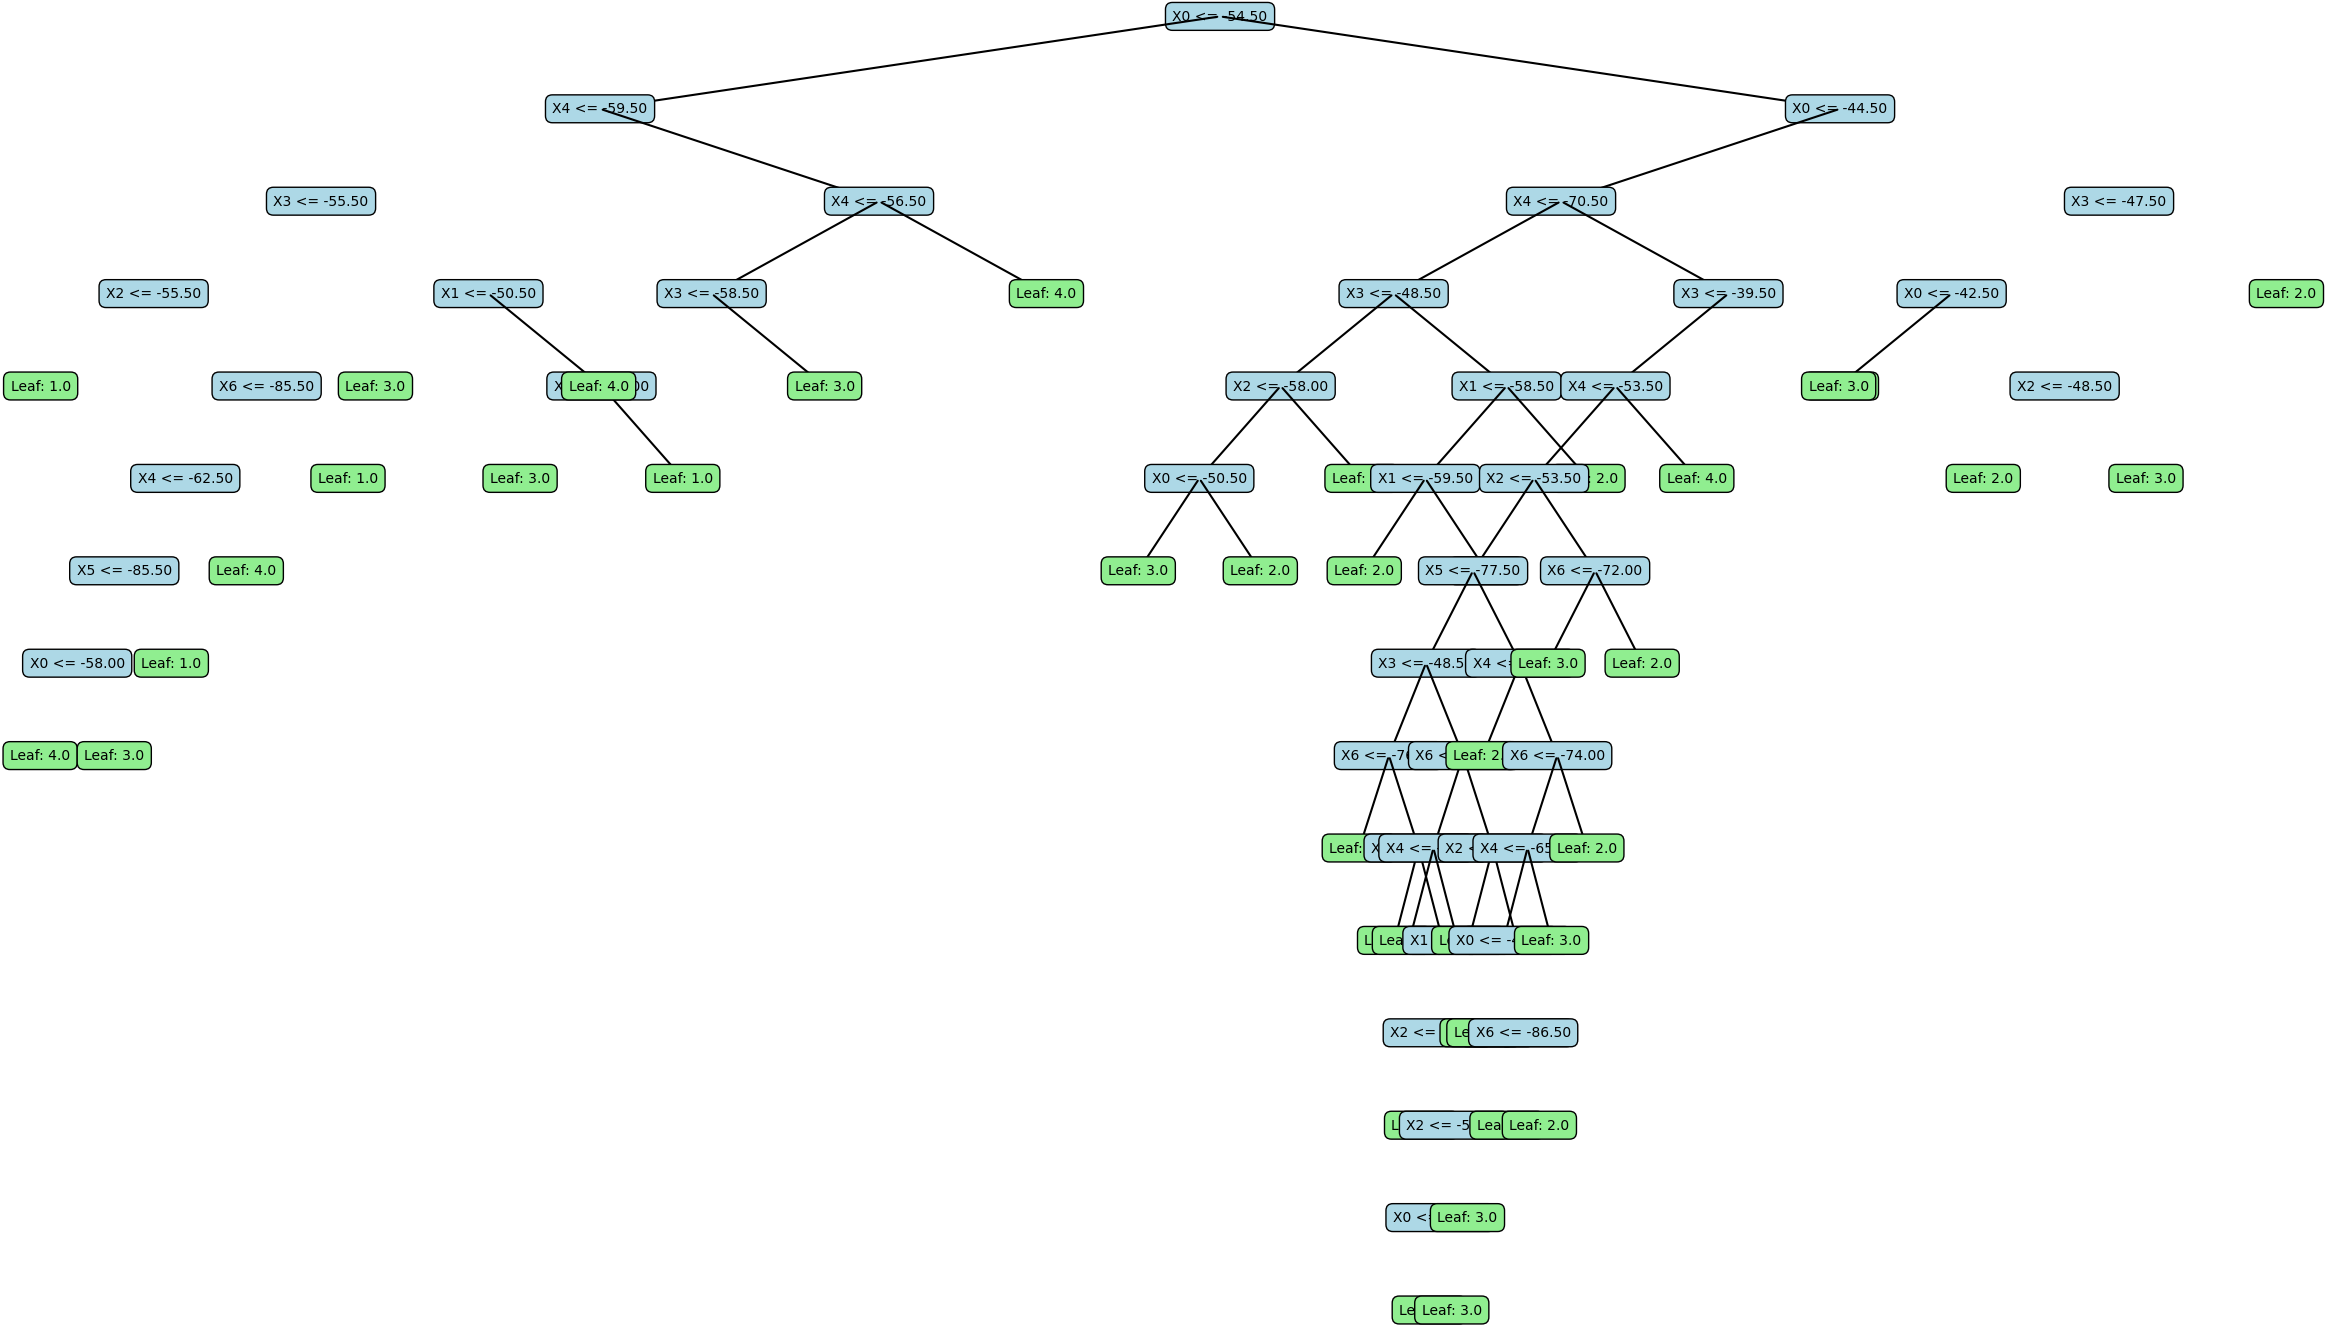

In [41]:
Decision_Tree_cls = DecisionTreeClassifier()
Decision_Tree_cls.fit(clean_data)
Decision_Tree_cls.plot_tree()